## Imports

In [1]:
import numpy as np 
import pickle
import matplotlib.pyplot as plt

## Reading Databases

In [2]:
class Vertex():
    def __init__(self, name):
        self.name = name
        self.edges = []
        self.weights = []
        self.pheromone = [] 
    
    def add(self, other, weight):
        self.edges.append(other)
        self.weights.append(weight)
        self.pheromone.append(10)  # Inicialize pheromone equals 10 to all edges

In [3]:
class Graph():
    def __init__(self):
        self.vertices = dict()
    
    def build_graph(self, file):
        with open(file) as f:
            lines = f.readlines()
            lines = [line.strip() for line in lines]
            for line in lines:
                line = line.split('\t')
                line = list(map(float, line))
                if line[0] not in self.vertices.keys():
                    self.vertices[line[0]] = Vertex(line[0])
                self.vertices[line[0]].add(line[1], line[2])
    
    def update_pheromone(self, origin, destine, cost):
            index = self.vertices[origin].edges.index(destine)
            self.vertices[origin].pheromone[index] += cost
    
    def evaporate_pheromone(self, evaporation_rate):
        for vertex in self.vertices.keys():
            #self.vertices[vertex].pheromone -= np.array(evaporation_rate)
            self.vertices[vertex].pheromone *= np.array(1-evaporation_rate)
            self.vertices[vertex].pheromone = np.clip(self.vertices[vertex].pheromone, a_min=0, a_max=None)
    
    def show_pheromone(self):
        for vertex in self.vertices.keys():
            print(self.vertices[vertex].pheromone)
    
    def reset_pheromone(self):
        for vertex in self.vertices.keys():
            self.vertices[vertex].pheromone = [10 for _ in self.vertices[vertex].pheromone]

In [4]:
file = 'graph1.txt'
G1 = Graph()
G1.build_graph(file)

## ACO 

In [5]:
class Ant():
    def __init__(self, destine):
        self.path = [1]
        self.destine = destine
    
    def show(self):
        for e in self.path[:-1]:
            print(e, end=', ')
        print(self.path[-1])
    
    def step(self, graph, alfa=1, beta=2):
        vertex = self.path[-1]
        edges = graph.vertices[vertex].edges
        pheromone = graph.vertices[vertex].pheromone
        weights = graph.vertices[vertex].weights
        index = [i for (i,e) in enumerate(edges) if e not in self.path]
        if index == []:
            
            return None, 0
        #edges = [e for (i,e) in enumerate(edges) if i in index]
        pheromone = [p for (i,p) in enumerate(pheromone) if i in index]
        v_weights = [w for (i,w) in enumerate(weights) if i in index]
        #print(edges)
        prob_num = np.array(pheromone)**alfa * np.array(v_weights)**beta
        prob = prob_num/np.sum(prob_num)
        chosen = np.random.choice(index, p=prob)
        destination = edges[chosen]
        cost = weights[chosen]
        self.path.append(destination)
        return destination, cost
        
    def walk(self, graph, alfa=1, beta=2):
        total_cost = 0
        destination = 1
        while(destination != self.destine and destination != None):
            destination, cost = self.step(graph, alfa, beta)
            # print(destination, len(self.path))
            ##Test
            ##if len(self.path) <= 99:
            ##     if destination == 100:
            ##            self.path.pop()
            ##            destination = 0
            ##            continue
            ## 
            total_cost += cost

        #self.show()
        if destination == None:
            print("DEAD END ")
            self.path=[1]  # Clear ant path before return 
            return 0, None
        #print("Total lenght = ", len(self.path))
        #print("Total weight = ", total_cost)
        
        # Reset ant path
        path = self.path 
        self.path = [1]  # Clear ant path before return 
        
        return total_cost, path


In [6]:
class ACO():
    def __init__(self, graph=None, number_of_ants=20, max_iterations=100, evaporation_rate=0.05, alfa=1, beta=2):
        self.number_of_ants = number_of_ants
        self.graph = graph
        self.ants = [Ant(len(self.graph.vertices)) for _ in range(self.number_of_ants)]
        self.max_iterations = max_iterations
        self.evaporation_rate = evaporation_rate
        self.current_iteration = 0
        self.best = (0, None)
        self.alfa = alfa
        self.beta = beta
        
    def iteration(self):
        self.current_iteration += 1
        
        #self.graph.show_pheromone()
        #Evaporate pheromone
        self.graph.evaporate_pheromone(self.evaporation_rate)
        
        fitness = []
        for ant in self.ants:
            
            cost, path = ant.walk(self.graph, self.alfa, self.beta)
            fitness.append(cost)
            if path == None:
                continue
            
            #Update best 
            if cost > self.best[0]:
                self.best = (cost, path)
        
            #Update pheromone
            for i, vertex in enumerate(path[:-1]):
                origin = vertex
                destine = path[i+1]
                self.graph.update_pheromone(origin, destine, cost/100)
        
        #print("Best so far: ", self.best[0])
        #print("Best so far: {},  Average fitness: {}".format(self.best[0], np.mean(fitness)))
        
        # Return iteration fitness (mean and best) 
        return np.mean(fitness), self.best[0]
    
    def run(self, number_of_ants=20, max_iterations=100, evaporation_rate=0.05, alfa=1, beta=2):
        self.number_of_ants = number_of_ants
        self.max_iterations = max_iterations
        self.evaporation_rate = evaporation_rate
        self.alfa = alfa
        self.beta = beta
        print("-----------------")
        print("Parameters: ")
        print("N of ants: ", self.number_of_ants)
        print("Max iterations: ", self.max_iterations)
        print("Evaporation rate: ", self.evaporation_rate)
        print("Alfa: ", self.alfa)
        print("Beta: ", self.beta)
        print("-----------------")
        
        
        best_list = []
        mean_list = []
        for i in range(self.max_iterations):
            mean, best = self.iteration()
            mean_list.append(mean)
            best_list.append(best)
        return mean_list, best_list
    
    def reset(self):
        self.current_iteration = 0
        self.best = (0, None)
        self.graph.reset_pheromone()
    
    def test_parameters_set(self, number_of_ants, max_iterations, evaporation_rate, alfa=1, beta=2, repetitions=10, directory='plots'):
        global_mean_list = []
        global_best_list = []
        for i in range(repetitions):
            self.reset()
            global_mean, global_best = self.run(number_of_ants, max_iterations, evaporation_rate, alfa=1, beta=2)
            global_mean_list.append(global_mean)
            global_best_list.append(global_best)
            print("Global best: {}, Mean fitness: {} \n".format(max(global_best), np.mean(global_mean)))
        
        final_mean = np.mean(global_mean_list, axis=0)
        final_best = np.mean(global_best_list, axis=0)
        mean_fitness_std = np.std(global_mean_list, axis=0)
        best_fitness_std = np.std(global_best_list, axis=0)
        
        ## Plotting 
        plt.figure(figsize=(12,6), dpi=100)
        plt.subplot(121)
        plt.suptitle('Parameters: N of ants: {}, Evaporation rate: {}, Max iterations = {}'.format(number_of_ants, evaporation_rate, max_iterations))
        plt.title("Best cost")
        plt.plot(final_best)
        plt.ylabel("Fitness")
        plt.xlabel("Iterations")

        plt.subplot(122)
        plt.title("Mean cost")
        plt.plot(final_mean)
        plt.ylabel("Fitness")
        plt.xlabel("Iterations")
        plt.subplots_adjust(hspace=8, wspace=0.4)

        OUTNAME = 'ants{}_evaporation{}_iterations{}'.format(number_of_ants, evaporation_rate, max_iterations)
        plt.savefig(directory + '/' + OUTNAME+'.png')
        
        ## Saving Pickle
        with open(directory + '/' + OUTNAME + '.pickle', 'wb') as f:
            pickle.dump([global_mean_list, global_best_list, final_mean, final_best, mean_fitness_std, best_fitness_std], f, pickle.HIGHEST_PROTOCOL)

## Problem 1

In [7]:
sol1 = ACO(G1)

In [8]:
#number_of_ants = 20
#max_iterations = 150
#evaporation_rate = 0.05
#mean, best = sol1.run(number_of_ants, max_iterations, evaporation_rate)

In [9]:
#for evaporation_rate in [0.01, 0.03, 0.05]:
#    for number_of_ants in [20, 40, 70]:
#        for max_iterations in [100, 150, 200]:
#            sol1.test_parameters_set(number_of_ants, max_iterations, evaporation_rate, repetitions=10, directory='plots1')

## Problem 2

In [10]:
file = 'graph2.txt'
G2 = Graph()
G2.build_graph(file)
sol2 = ACO(G2)

In [11]:
#number_of_ants = 20
#max_iterations = 150
#evaporation_rate = 0.01
#alfa = 1
#beta = 2
#sol2 = ACO(G2, number_of_ants, max_iterations, evaporation_rate, alfa, beta)

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.005
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 168.0, Mean fitness: 63.72133333333334 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.005
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 160.0, Mean fitness: 67.547 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.005
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 

DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 167.0, Mean fitness: 68.35533333333333 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.02
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 167.0, Mean fitness: 68.97666666666667 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.02
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END

DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 167.0, Mean fitness: 76.93866666666668 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.05
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 167.0, Mean fitness: 66.82633333333334 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.05
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 167.0, Mean fitness: 79.51233333333333 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.07
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD EN

DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 159.0, Mean fitness: 102.623 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.12
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 167.0, Mean fitness: 89.606 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.12
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 167.0, Mean fitness: 96.935 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.12
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
Global best: 167.0, Mean fitness: 84.28633333333333 

-----------------
Parameters: 
N of ants:  20
Max iterations:  150
Evaporation rate:  0.12
Alfa:  1
Beta:  2
-----------------
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END 
DEAD END

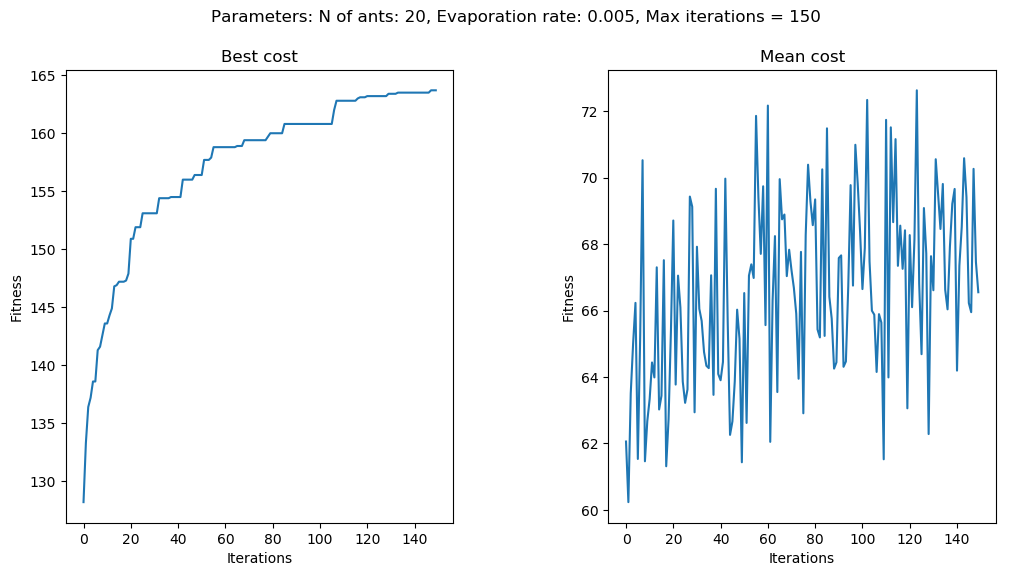

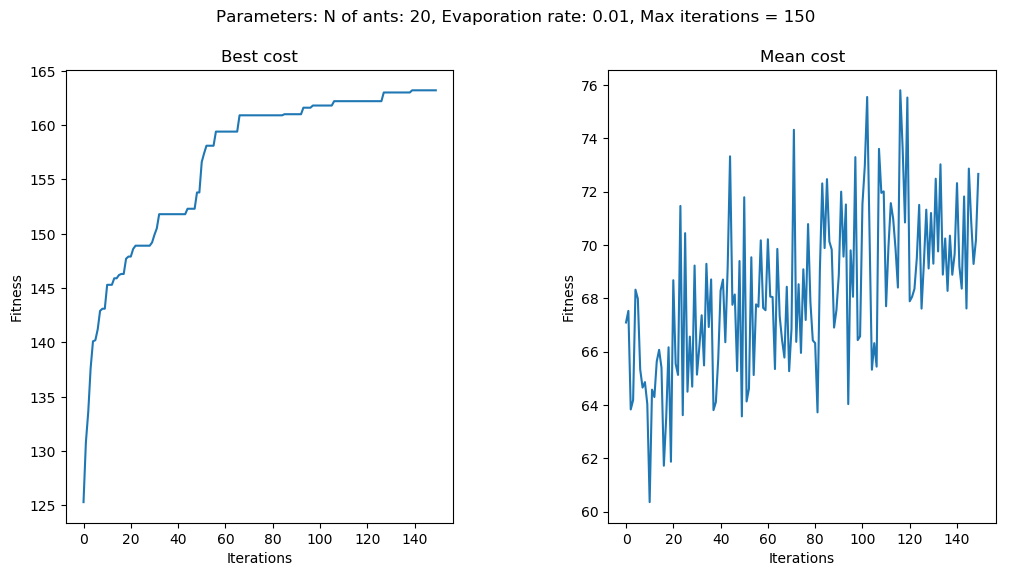

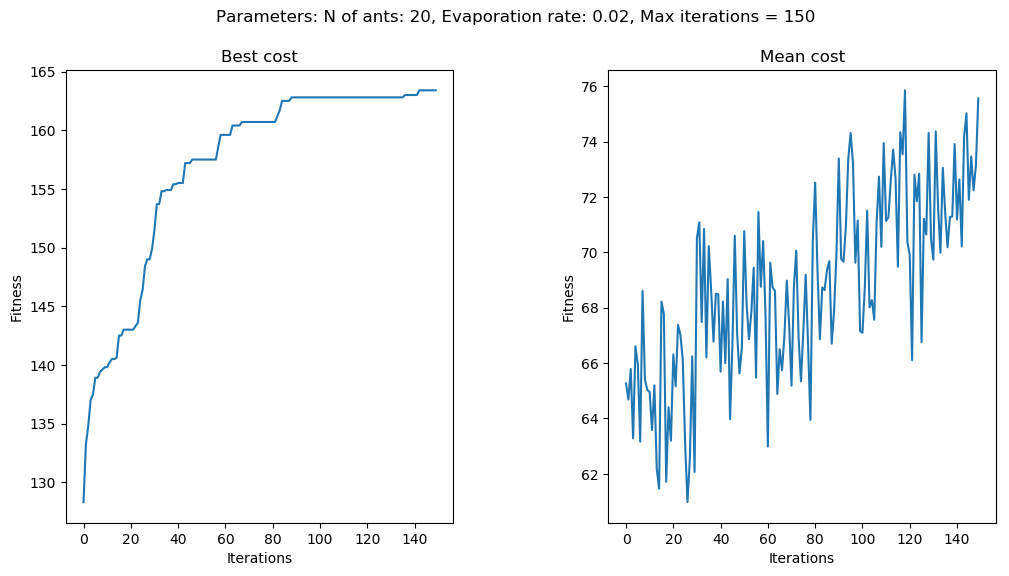

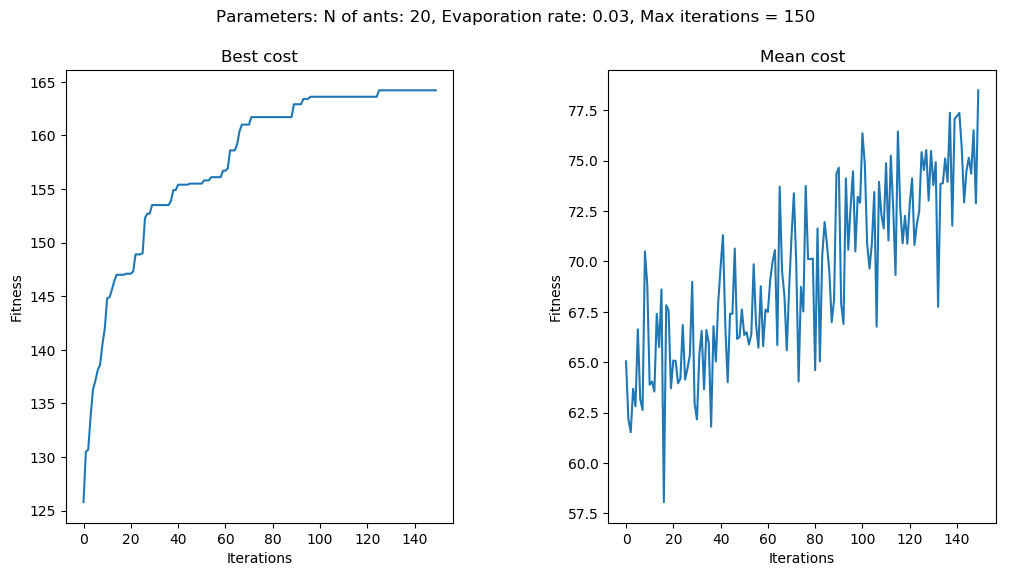

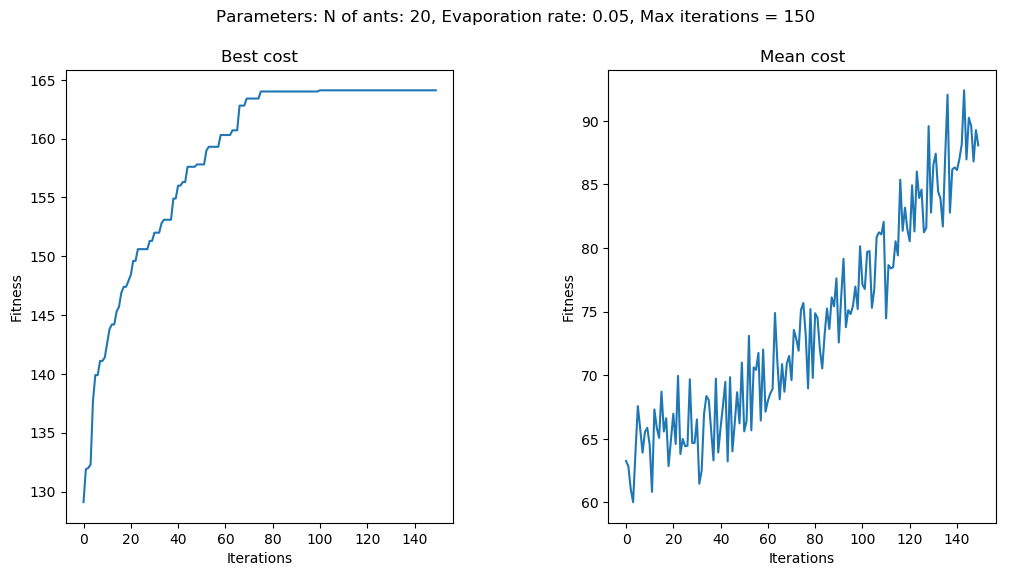

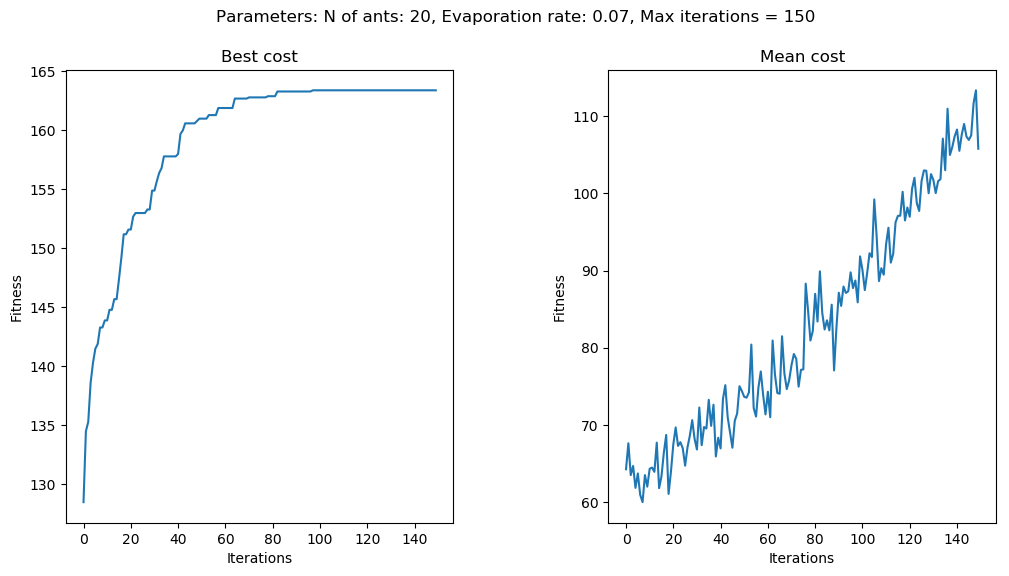

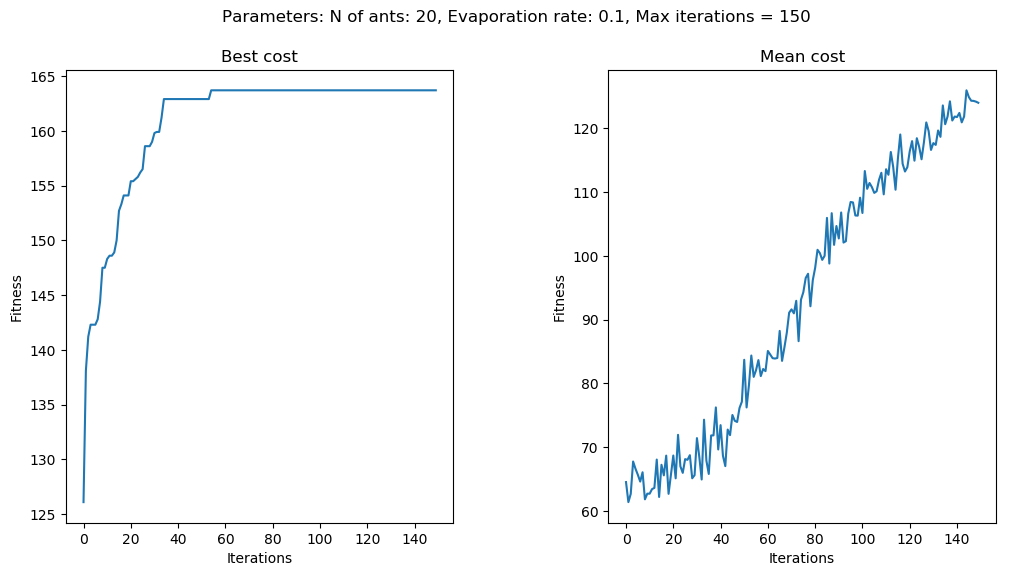

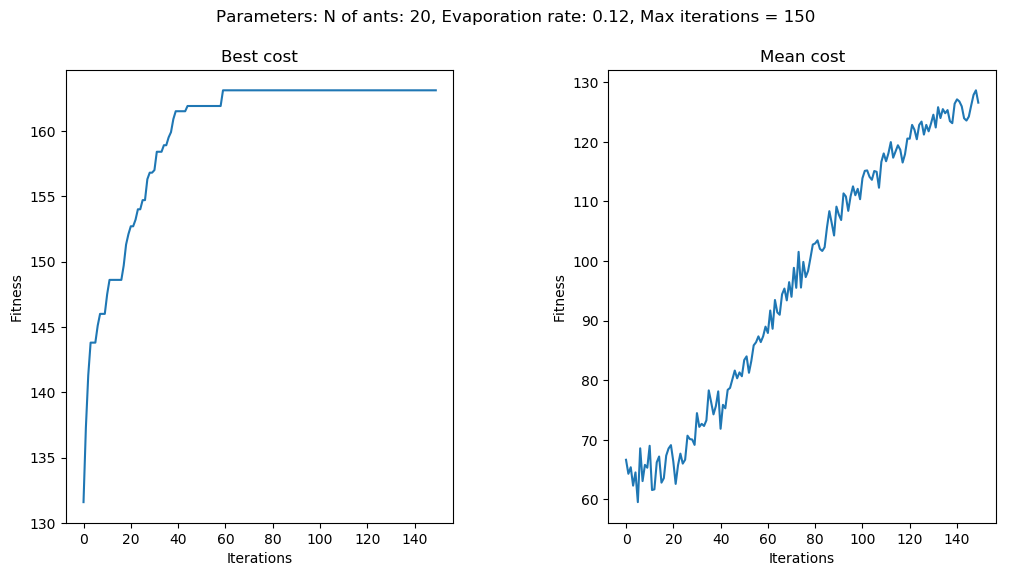

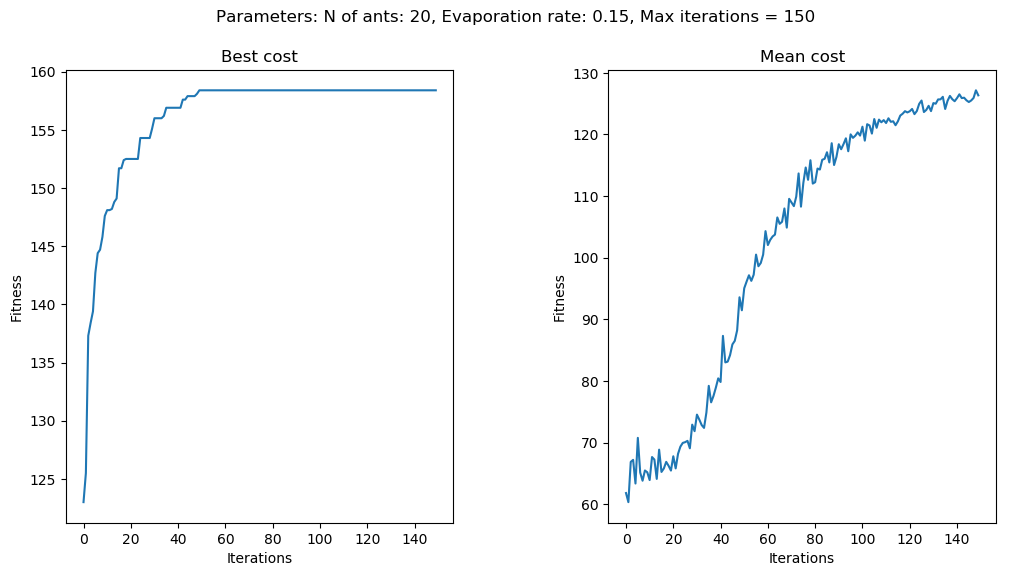

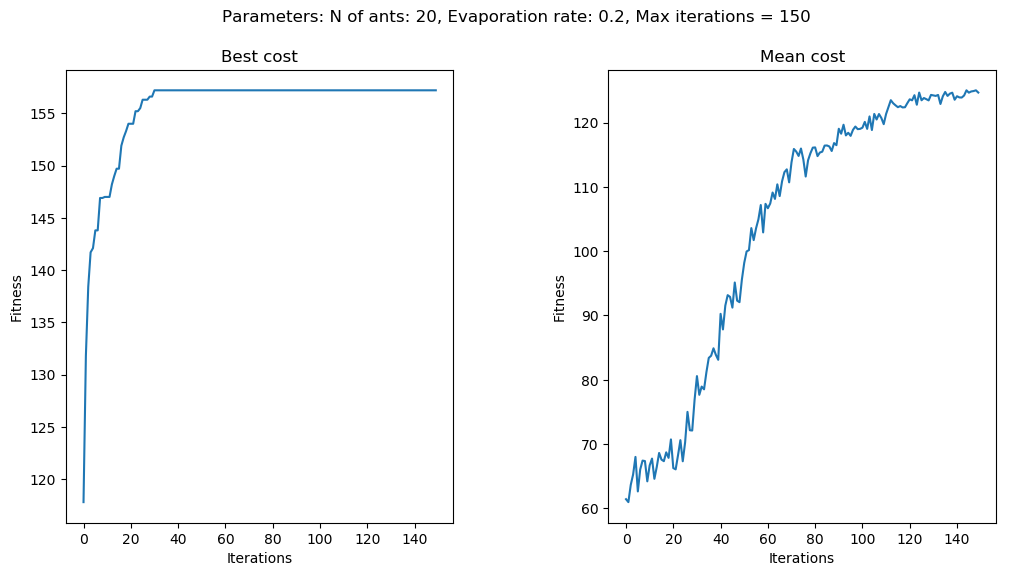

In [14]:
#number_of_ants = 20
#max_iterations = 150
#for evaporation_rate in [0.005, 0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.12, 0.15, 0.2]:
#    sol2.test_parameters_set(number_of_ants, max_iterations, evaporation_rate, repetitions=10, directory='plots2')

## Problem 3

In [15]:
file = 'graph3.txt'
G3 = Graph()
G3.build_graph(file)
sol3 = ACO(G3)

In [ ]:
evaporation_rate = 0.05
number_of_ants = 20
for max_iterations in [200]:
    sol3.test_parameters_set(number_of_ants, max_iterations, evaporation_rate, repetitions=10, directory='plots3')

-----------------
Parameters: 
N of ants:  20
Max iterations:  200
Evaporation rate:  0.05
Alfa:  1
Beta:  2
-----------------
DEAD END 
